<a href="https://colab.research.google.com/github/IrfEazy/msc-thesis/blob/main/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
!pip install nltk -qqq
!pip install rake-nltk -qqq
!pip install tensorflow -qqq


In [2]:
import gzip
import os
import shutil
import string
from collections import Counter
from pathlib import Path

import gensim.models
import inflect
import joblib
import nltk
import numpy as np
import pandas as pd
import spacy
from google.colab import drive
from matplotlib import pyplot as plt
from nltk import PorterStemmer
from nltk.corpus import stopwords
from rake_nltk import Rake
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.python.keras.preprocessing.text import Tokenizer
from transformers import pipeline


In [3]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Environment Settings


In [5]:
RANDOM_SEED = 42
X_CSV = 'data/X.csv'
X_JSON = 'data/X.json'


In [4]:
# Change current directory into /content/drive/My Drive/Tesi/thesis, and if the folder thesis is not available, create it
drive.mount('/content/drive')

# Define the target directory
target_dir = "/content/drive/My Drive/thesis"

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Change the current working directory
os.chdir(target_dir)

# Verify the directory change
print("Current working directory:", os.getcwd())


Mounted at /content/drive
Current working directory: /content/drive/My Drive/thesis


In [6]:
# Decompress the model in 'models/GoogleNews-vectors-negative300.bin.gz' in the same folder
# Path to the decompressed model file
compressed_word2vec_path = 'models/GoogleNews-vectors-negative300.bin.gz'
word2vec_path = 'models/GoogleNews-vectors-negative300.bin'


# Check if the decompressed file already exists
if os.path.exists(word2vec_path):
    print("File already decompressed.")
else:
    # Check if the compressed file exists
    if os.path.exists(compressed_word2vec_path):
        try:
            with gzip.open(compressed_word2vec_path, 'rb') as f_in:
                with open(word2vec_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print("File decompressed successfully.")
        except Exception as e:
            print(f"An error occurred during decompression: {e}")
    else:
        # Download the file from Google Drive if it's not present
        !wget -O "$compressed_word2vec_path" "https://drive.usercontent.google.com/download?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download&authuser=0&confirm=t&uuid=7d62ae10-fee5-4471-a14b-d3fc3c8de6cf&at=AENtkXYp0oeqJDsqv8DR2sbelnZ5%3A1732188868578"
        print("File downloaded successfully.")
        try:
            with gzip.open(compressed_word2vec_path, 'rb') as f_in:
                with open(word2vec_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            print("File decompressed successfully.")
        except Exception as e:
            print(f"An error occurred during decompression: {e}")

File already decompressed.


# Functions

In [12]:
def replace_digits_with_words(tokens):
    inflect_engine = inflect.engine()
    return [inflect_engine.number_to_words(token) if token.isdigit() else token for token in tokens]


# [A Framework for Unsupervised Classification and Data Mining of Tweets about Cyber Vulnerabilities](https://arxiv.org/abs/2104.11695)

Recent studies have indicated that the NVD is not always up to date, with known vulnerabilities being discussed publicly on social media platforms, like Twitter and Reddit, months before they are published to the NVD. To that end, we present a framework for unsupervised classification to filter tweets for relevance to cybersecurity. We consider and evaluate two unsupervised ML techniques for inclusion in our framework, and show that zero-shot classification using a Bidirectional and Auto-Regressive Transformers (BART) model outperforms the other technique with 83.52% accuracy and a F1 score of 83.88%, allowing for accurate filtering of tweets without human intervention or labelled data for training.

Additionally, we discuss different insights that can be derived from these cyber-relevant tweets, such as trending topics of tweets and the counts of Twitter mentions for Common Vulnerabilities and Exposures (CVEs), that can be used in an alert or report to augment current NVD-based risk assessment tools.


In this experiment, the unsupervised techniques were evaluated on a labelled dataset of tweets from Behzadan et al.


## [Corpus and Deep Learning Classifier for Collection of Cyber Threat Indicators in Twitter Stream](https://ieeexplore.ieee.org/document/8622506)

A corpus of 21.000 tweets was curated directly from [Twitter](https://github.com/behzadanksu/cybertweets)


In [25]:
# Load JSON dataset
THREAT_TWEETS_JSON = Path('data/threat.tweets.json')

# Load JSON into a pandas DataFrame
threat_tweets = pd.read_json(path_or_buf=THREAT_TWEETS_JSON)


In [27]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

x['body'] = threat_tweets['text']

# 1. Conversion of all characters of the tweet to lower case
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].str.lower()

# 2. Tokenize the text according to white-space separations
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].str.split()

# 3. Remove tokens that are not encoded in ASCII
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(
    lambda tokens: [token for token in tokens if token.isascii()]
)

# 4. Remove punctuation from each token
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(
    lambda tokens: [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
)

# 5. Remove tokens that are not comprised of alphanumeric characters
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(
    lambda tokens: [token for token in tokens if token.isalnum()]
)

# 6. Substitute digits with word representations (e.g., 4 -> four)
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(replace_digits_with_words)

# 7. Remove stop words
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

# 8. Stem tokens
threat_tweets['preprocess-text'] = threat_tweets['preprocess-text'].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens]
)


In [28]:
threat_tweets


,_id,date,id,relevant,text,tweet,type,watson,annotation,preprocess-text
0,{'$oid': '5b88752abb325e65390af240'},{'$date': '2018-08-30T22:52:25.000Z'},1035299228984041472,False,Best way to build empathy is through honesty a...,{'created_at': 'Thu Aug 30 22:52:25 +0000 2018...,[vulnerability],"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,"[best, way, build, empathi, honesti, vulner]"
1,{'$oid': '5b8875d5bb325e65a22cf81b'},{'$date': '2018-08-30T22:55:15.000Z'},1035299941932036096,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:55:15 +0000 2018...,[ransomware],"{'usage': {'text_units': 1, 'text_characters':...",business,"[cryptocurr, scam, replac, ransomwar, attack, ..."
2,{'$oid': '5b88768dbb325e65fa7e78e3'},{'$date': '2018-08-30T22:58:20.000Z'},1035300715470757888,False,Cryptocurrency Scams Replacing Ransomware as A...,{'created_at': 'Thu Aug 30 22:58:20 +0000 2018...,[ransomware],"{'usage': {'text_units': 1, 'text_characters':...",business,"[cryptocurr, scam, replac, ransomwar, attack, ..."
3,{'$oid': '5b8876f9bb325e65fa7e78e4'},{'$date': '2018-08-30T23:00:08.000Z'},1035301167952211968,True,Protect your customers access Prestashop Ant...,{'created_at': 'Thu Aug 30 23:00:08 +0000 2018...,[ddos],"{'usage': {'text_units': 1, 'text_characters':...",threat,"[protect, custom, access, prestashop, anti, dd..."
4,{'$oid': '5b8876f9bb325e65fa7e78e5'},{'$date': '2018-08-30T23:00:09.000Z'},1035301173178249216,True,Data leak from Huazhu Hotels may affect 130 mi...,{'created_at': 'Thu Aug 30 23:00:09 +0000 2018...,[leak],"{'usage': {'text_units': 1, 'text_characters':...",threat,"[data, leak, huazhu, hotel, may, affect, one h..."
...,...,...,...,...,...,...,...,...,...,...
21363,{'$oid': '5b982924bb325e3cadebf9ad'},{'$date': '2018-09-11T20:44:19.000Z'},1039615645883789312,False,@FuddBot (cont'd) ... Spikes in tweet volume: ...,{'created_at': 'Tue Sep 11 20:44:19 +0000 2018...,[botnet],"{'usage': {'text_units': 1, 'text_characters':...",business,"[fuddbot, contd, spike, tweet, volum, twenty m..."
21364,{'$oid': '5b982928bb325e3cadebf9ae'},{'$date': '2018-09-11T20:44:24.000Z'},1039615665584259072,True,@NarutoRomania ransomware content blackmail fo...,{'created_at': 'Tue Sep 11 20:44:24 +0000 2018...,[ransomware],"{'usage': {'text_units': 1, 'text_characters':...",threat,"[narutoromania, ransomwar, content, blackmail,..."
21365,{'$oid': '5b982929bb325e3cadebf9af'},{'$date': '2018-09-11T20:44:25.000Z'},1039615668814077952,True,Make sure you have upgraded to #tor 8.0 #priva...,{'created_at': 'Tue Sep 11 20:44:25 +0000 2018...,[general],"{'usage': {'text_units': 1, 'text_characters':...",threat,"[make, sure, upgrad, tor, eighti, privaci, tor..."
21366,{'$oid': '5b98294abb325e3cadebf9b0'},{'$date': '2018-09-11T20:44:58.000Z'},1039615806303133696,False,@JennMGreenberg @MindingTheKings I was thinkin...,{'created_at': 'Tue Sep 11 20:44:58 +0000 2018...,[general],"{'usage': {'text_units': 1, 'text_characters':...",irrelevant,"[jennmgreenberg, mindingthek, think, pregnanc,..."


In [29]:
def create_cnn_model():
    model = Sequential()

    # Convolutional layer with 32 filters, kernel size 8, and ReLU activation
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu', input_shape=(300, 1)))

    # Pooling layer with size 2
    model.add(MaxPooling1D(pool_size=2))

    # Flatten the output
    model.add(Flatten())

    # Fully connected layer with 30 ReLU cells
    model.add(Dense(30, activation='relu'))

    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    return model


In [47]:
# Instantiate the model
model = create_cnn_model()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'recall', 'precision', 'f1_score'])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)                    │ (None, 293, 32)             │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 146, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 4672)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30)                  │         140,190 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 140,509 (548.86 KB)

 Trainable params: 140,509 (548.86 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
def sentence_to_embedding(sentence, model, embedding_dim):
    # Initialize a list to store the embeddings for the words in the sentence
    word_embeddings = []

    for word in sentence:
        # Check if the word exists in the model's vocabulary
        if word in model.key_to_index:
            word_embeddings.append(model[word])
        else:
            # If the word is not in the vocabulary, use a zero vector
            word_embeddings.append(np.zeros(embedding_dim))

    # If no words are in the vocabulary, return a zero vector
    if len(word_embeddings) == 0:
        return np.zeros(embedding_dim)

    # Average the word embeddings to get the sentence embedding
    sentence_embedding = np.mean(word_embeddings, axis=0)

    return sentence_embedding


In [50]:
embedder = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

X = np.array([
    sentence_to_embedding(words, embedder, embedding_dim=300)
    for words in threat_tweets['preprocess-text']
])
y = np.array([1. if yi == True else 0. for yi in threat_tweets['relevant']])


In [51]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val,
    test_size=0.5,
    random_state=RANDOM_SEED,
    stratify=y_val
)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict
).history


Epoch 1/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6961 - f1_score: 0.6863 - loss: 0.5816 - precision: 0.7219 - recall: 0.6773 - val_accuracy: 0.7562 - val_f1_score: 0.6845 - val_loss: 0.5005 - val_precision: 0.7988 - val_recall: 0.7104
Epoch 2/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7529 - f1_score: 0.6868 - loss: 0.4974 - precision: 0.7758 - recall: 0.7422 - val_accuracy: 0.7567 - val_f1_score: 0.6845 - val_loss: 0.4869 - val_precision: 0.8149 - val_recall: 0.6888
Epoch 3/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7742 - f1_score: 0.6825 - loss: 0.4678 - precision: 0.7976 - recall: 0.7562 - val_accuracy: 0.7702 - val_f1_score: 0.6845 - val_loss: 0.4767 - val_precision: 0.7611 - val_recall: 0.8138
Epoch 4/100
535/535 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7763 - f1_score: 0.6859 - loss: 0.4541 - precision: 0.7968 - recall: 0.7671 - val_accuracy: 0.7712 - val_f1_score: 0.6845 - val_loss: 0.4702 - val_precision: 0.7860 - val_rec

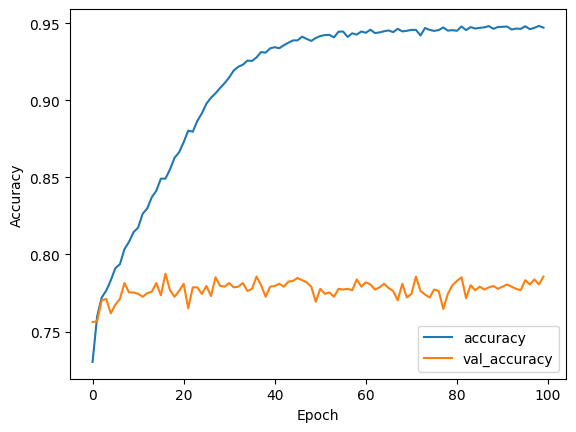

In [52]:
# Display the training history
plt.plot(history['accuracy'], label='accuracy')
plt.plot(history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [53]:
# Evaluate the model
loss, accuracy, recall, precision, f1 = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Loss: 0.8641
Accuracy: 0.7843
Recall: 0.7678
Precision: 0.8078
F1 Score: 0.6862


In [14]:
x = pd.read_csv(filepath_or_buffer=X_CSV)


In [15]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# 1. Conversion of all characters of the tweet to lower case
x['body'] = x['body'].str.lower()

# 2. Tokenize the text according to white-space separations
x['body'] = x['body'].str.split()

# 3. Remove tokens that are not encoded in ASCII
x['body'] = x['body'].apply(
    lambda tokens: [token for token in tokens if token.isascii()]
)

# 4. Remove punctuation from each token
x['body'] = x['body'].apply(
    lambda tokens: [token.translate(str.maketrans('', '', string.punctuation)) for token in tokens]
)

# 5. Remove tokens that are not comprised of alphanumeric characters
x['body'] = x['body'].apply(
    lambda tokens: [token for token in tokens if token.isalnum()]
)

# 6. Substitute digits with word representations (e.g., 4 -> four)
x['body'] = x['body'].apply(replace_digits_with_words)

# 7. Remove stop words
x['body'] = x['body'].apply(
    lambda tokens: [word for word in tokens if word.lower() not in stop_words]
)

# 8. Stem tokens
x['body'] = x['body'].apply(
    lambda tokens: [stemmer.stem(token) for token in tokens]
)


In [16]:
x


,sma_id,post_id,title,body,sourcetype,full_text,language,data_created,created
0,72,1855407258336657712,NaN,"[also, httpstcoeje8ahokhx, httpstco6yfgx6srr2]",Twitter,'/6yfgx6srr2':11 '/eje8ahokhx':7 'also':3 'm':...,en,2024-11-10T00:28:56,2024-11-10T00:28:56
1,90,1855405259881123899,NaN,"[eff, best, stake, high, httpstcoaspodcbppf]",Twitter,'/aspodcbppf':13 'best':5 'eff':1 'high':10 's...,en,2024-11-10T00:21:00,2024-11-10T00:21:00
2,86,1855401615685009538,NaN,"[mediaphyt, drstacythay, pictur, made, smile, ...",Twitter,'amazing':9 'drstacythayer':2 'made':5 'mediap...,en,2024-11-10T00:06:31,2024-11-10T00:06:31
3,90,1855366756031725721,NaN,"[today, 2pm, pt, aaronswartzday, celebr, digit...",Twitter,'/mixvd7f8ca':32 '2pm':3 'aaronswartzday':5 'a...,en,2024-11-09T21:48:00,2024-11-09T21:48:00
4,78,1855359051019993197,NaN,"[cyb3rmonk, oh, god, move, averag, vendor, cha...",Twitter,'averages':5 'changed':9 'cyb3rmonk':1 'gods':...,en,2024-11-09T21:17:23,2024-11-09T21:17:23
...,...,...,...,...,...,...,...,...,...
3496,59,1847232684936024207,NaN,"[eset, deni, compromis, isra, org, target, ese...",Twitter,'/fmmu9nnsew':20 '/ykbe1ksgqy':17 'branded':13...,en,2024-10-18T11:06:06,2024-10-18T11:06:06
3497,59,1847231548762063027,NaN,"[instagram, roll, new, sextort, protect, measu...",Twitter,'/aqbqijj8xm':10 '/hmyeq5leb8':13 'instagram':...,en,2024-10-18T11:01:35,2024-10-18T11:01:35
3498,59,1847231198936068437,NaN,"[bewar, fake, googl, meet, page, deliv, infost...",Twitter,'/3iod9qfgnr':14 '/k37qt6wnnm':17 'beware':1 '...,en,2024-10-18T11:00:12,2024-10-18T11:00:12
3499,69,1847231182787780966,NaN,"[instagram, roll, new, sextort, protect, measu...",Twitter,'/cpipxmro5m':10 'instagram':1 'measures':7 'n...,en,2024-10-18T11:00:08,2024-10-18T11:00:08


## Continue


The dataset contains 21.368 tweets collected over four days using common cybersecurity keywords, and were labelled as 'threat', 'business', 'unknown', and 'irrelevant'. Since we focus on vulnerabilities, we first filtered the dataset for tweets that contain the term 'vulnerability', which came out to 9.963 tweets.


In [ ]:
x = pd.read_csv(filepath_or_buffer=X_CSV)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts=x['body'])
X = np.array([
    sentence_to_embedding(words, embedder, embedding_dim=300)
    for words in threat_tweets['preprocess-text']
])


In [ ]:
pipe = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

sequence_to_classify = "tohkkis i draw   s stick men w or l offer"
candidate_labels = ['cyber security related', 'not cyber security related']
pipe(sequence_to_classify, candidate_labels)
